In [1]:
import quandl
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
quandl.ApiConfig.api_key = 'iB1vwTHbXzBdG755yy2W'

In [3]:
## returns direction of a time sorted df from earliest time -> more recent time, start date and end date.
def get_df_date_info(series):
    d1 = series.iloc[0].name
    d2 = series.iloc[-1].name
    if d1 < d2:
        #low -> high
        return [1, d1, d2]
    if d2 < d1:
        #high -> low
        return [-1, d2, d1]
    
def get_df_date_frequency(series):
    # daily, weekly, fortnightly, monthly, quarterly, annual
    ms = series.index
    difference = ms.to_series() - ms.to_series().shift()
    difference_mean = difference.mean()
    days = difference_mean.days
    hours = difference_mean.seconds/3600
    if hours >= 12.0:
        days += 1
    return days
    

class SERIES:
    def __init__(self,name,dataframe):
        self.name = name
        self.df = dataframe
        
        time_data = get_df_date_info(dataframe)
        self.direction = time_data[0]
        self.start_date = time_data[1]
        self.end_date = time_data[2]
        self.freq = get_df_date_frequency(dataframe)
        ##print(self.name, self.start_date.year, self.start_date.month)

In [4]:
class STOCK: ## Need to inherit from macro_series
    def __init__(self,stock_code,dateframe):
        self.stock_code = stock_code

In [5]:
def calculate_pct_change(df):
    return df.join(df.pct_change().iloc[:,0].rename('pct_change'))

def normalise(df):
    norm = df.iloc[:,0] / np.absolute(df.iloc[:,0].max())
    return df.join(norm.rename('norm'))

In [6]:
def get_macro_data():
    macro_data = {}
    macro_data['us_tr_bill_3m'] = SERIES('us_tr_bill_3m',
                                         calculate_pct_change(normalise(quandl.get('FRED/TB3MS',column_index='1'))) )
    macro_data['us_gdp_potential'] = SERIES('us_gdp_potential',
                                            calculate_pct_change(normalise(quandl.get('FRED/GDPPOT', column_index='1'))) )
    macro_data['us_nat_unemployment'] = SERIES('us_nat_unemployment',
                                               calculate_pct_change(normalise(quandl.get('FRED/NROUST',column_index='1'))) )

    pred_gov_net_lending_keys = {'FRED/GGNLBPDEA188N':'Germany','FRED/GGNLBPFRA188N':'France','FRED/GGNLBPJPA188N':'Japan','FRED/GGNLBPCAA188N':'Canada',
                                 'FRED/GGNLBPCNA188N':'China','FRED/GGNLBPRUA188N':'Russia','FRED/GGNLBAGBA188N':'UK','FRED/GGNLBPEZA188N':'EU',
                                 'FRED/GGNLBPUSA188N':'US','FRED/GGNLBAINA188N':'India'}

    pred_gov_net_lending = []
    for i in pred_gov_net_lending_keys:
        name = pred_gov_net_lending_keys[i] + '_pred_gov_net_lending'
        pred_gov_net_lending.append( SERIES(name,
                                            calculate_pct_change(normalise(quandl.get(i,column_index='1'))) ))
    macro_data['pred_gov_net_lending'] = pred_gov_net_lending
    
    macro_data['fed_total_public_debt'] = SERIES('fed_total_public_debt', 
                                                 calculate_pct_change(normalise(quandl.get('FRED/GFDEBTN',column_index='1'))) )

    gov_gross_debt_keys = {'FRED/GGGDTADEA188N':'Germany','FRED/GGGDTAFRA188N':'France','FRED/GGGDTAJPA188N':'Japan','FRED/GGGDTACAA188N':'Canada',
                           'FRED/GGGDTACNA188N':'China','FRED/GGGDTARUA188N':'Russia','FRED/GGGDTAGBA188N':'UK','FRED/GGGDTAEZA188N':'EU',
                           'FRED/GGGDTAUSA188N':'US','FRED/GGGDTAINA188N':'India',}
    gov_gross_debt = []
    for i in gov_gross_debt_keys:
        name = gov_gross_debt_keys[i] + '_gov_gross_debt'
        gov_gross_debt.append( SERIES(name,
                                      calculate_pct_change(normalise(quandl.get(i,column_index='1'))) ))
    macro_data['gov_gross_debt'] = gov_gross_debt
    
    macro_data['crude_oil_historical'] = SERIES('crude_oil_historical', 
                                                calculate_pct_change(normalise(quandl.get('BP/CRUDE_OIL_PRICES',column_index='1'))) )
    
    macro_data['crude_oil_opec'] = SERIES('crude_oil_opec',
                                          calculate_pct_change(normalise(quandl.get('OPEC/ORB',column_index='1'))) )
    
    macro_data['gold_price'] = SERIES('gold_price',
                                      calculate_pct_change(normalise(quandl.get('LBMA/GOLD',column_index='1'))) )
    return macro_data

In [7]:
def skewed_normal(mu, sigma, minimum, maximum):
    while True:
        s = np.rint(np.random.normal(mu, sigma)).astype(int)
        if (minimum < s & s < maximum ):
            break  
    return s

def split_df(df, mu=20, sigma=30, minimum=5, maximum=150):
    ub = math.floor(len(df)/2)    
    if (maximum > ub):
        maximum = ub
    interval_start,interval_number,intervals = 0,1,df.iloc[:,0].astype(int).as_matrix()
    intervals[:] = 0
    while True:
        s = skewed_normal(mu,sigma,minimum,maximum)
        intervals[interval_start:interval_start+s] = interval_number
        interval_number += 1
        interval_start += s
        if interval_start > len(df) - 1:
            break
    
    intervals_pd = pd.Series(intervals,index=df.index).rename('Intervals')
    df = df.join(intervals_pd)
    return df

In [8]:
def analyse_macro_data(macro_data,stock_data,display=False):
    ### print("Length:",len(macro_data))
    count = 0
    for i in macro_data:
        count += 1
        ### print('-------------')
        ### print(i)
        ### print(type(macro_data[i]))
        macro_type_error = str('Value inputted:\n\n' + str(macro_data[i]) + '\n\nIs not of type list or class SERIES. It is of type ' + str(type(macro_data[i])))
        if type(macro_data[i]) is SERIES:
            ## SERIES analysis - global factor
            ### print('SERIES analysis')
            if display:
                plt.figure(count)
                plt.title(i)
                plt.plot(macro_data[i].df.iloc[:,1:])
            
        elif type(macro_data[i]) is list:
            for j in macro_data[i]:
                count += 1
                ### print(j.name)
                if type(j) is SERIES:
                    ## Macro Series analysis - per country
                    ### print('Macro_Series analysis - per country')
                    if display:
                        plt.figure(count)
                        plt.title(j.name)
                        plt.plot(j.df.iloc[:,1:])
                    
                else:
                    raise ValueError(macro_type_error)
        else:
            raise ValueError(macro_type_error)
    return

In [9]:
def read_format_stock(path):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df['1. open'] = df['1. open'].astype(float)
    df['2. high'] = df['2. high'].astype(float)
    df['3. low'] = df['3. low'].astype(float)
    df['4. close'] = df['4. close'].astype(float)
    df['5. volume'] = df['5. volume'].astype(float)
    return df

In [10]:
googl_path = os.path.join(os.getcwd(),"..","..","Data","GOOGL2.csv")
googl_df = SERIES('Google Price',read_format_stock(googl_path))
googl_df.df.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0


c:\users\multiple monitors\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


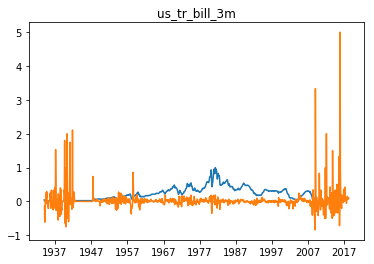

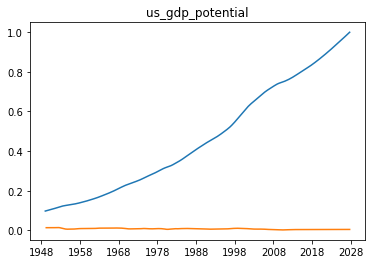

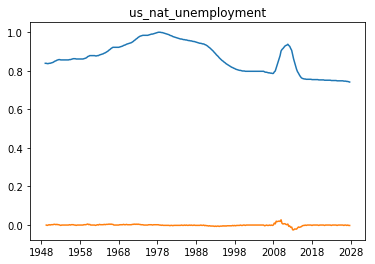

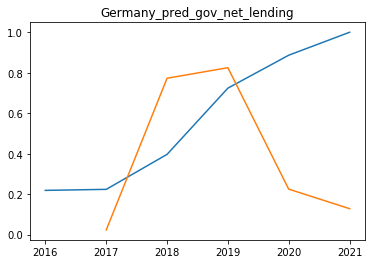

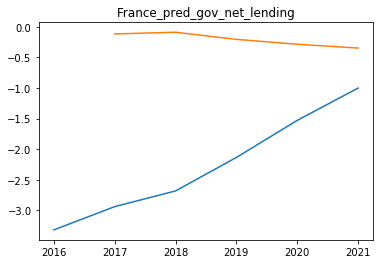

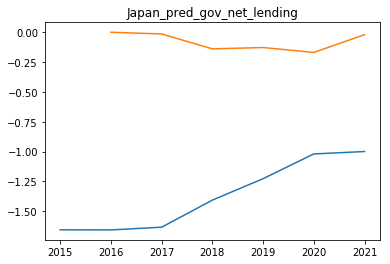

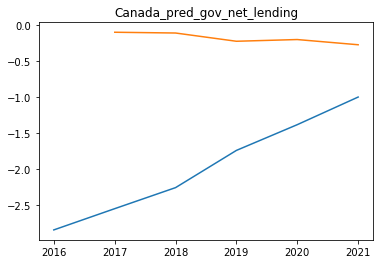

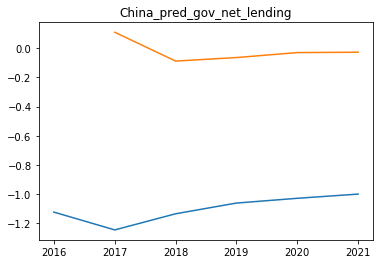

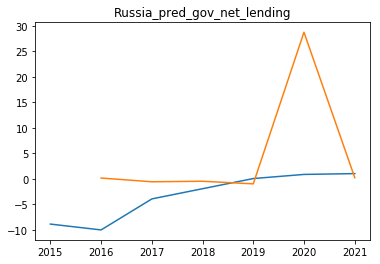

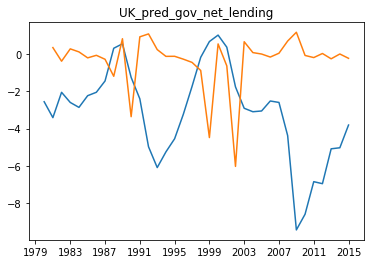

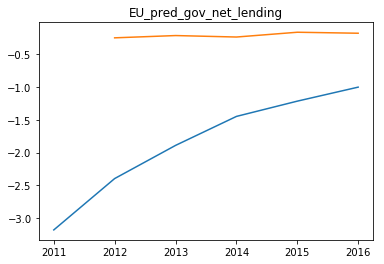

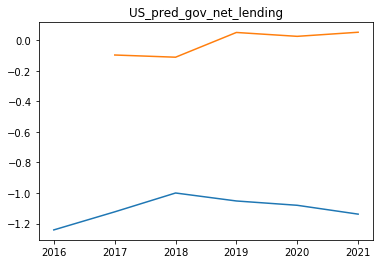

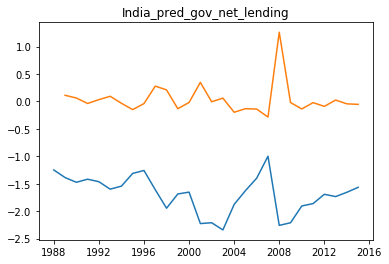

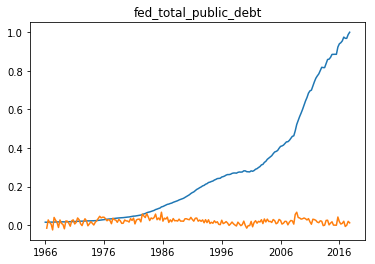

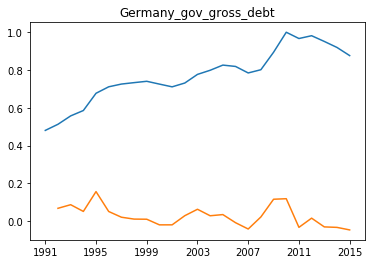

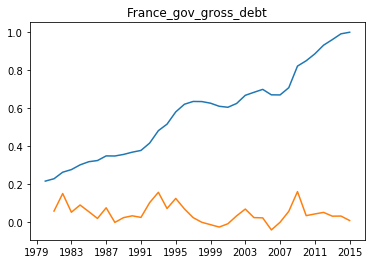

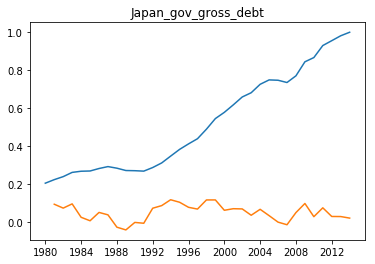

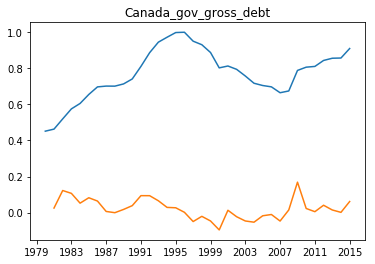

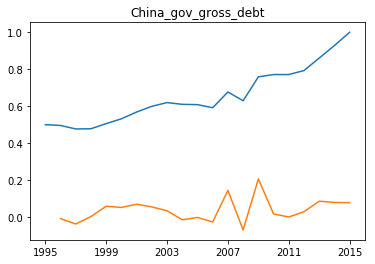

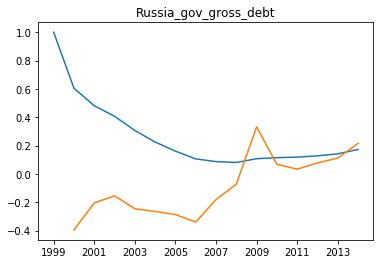

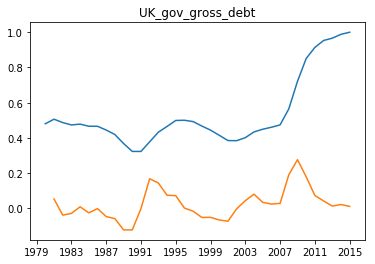

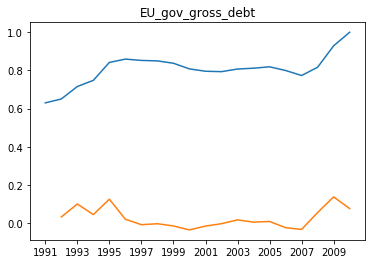

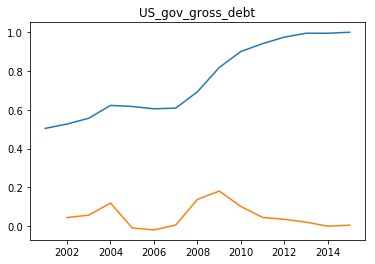

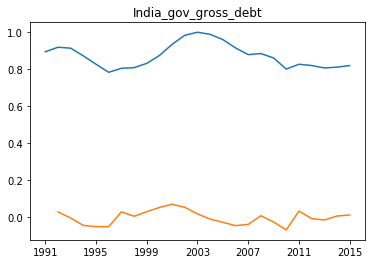

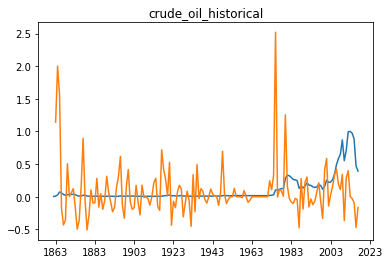

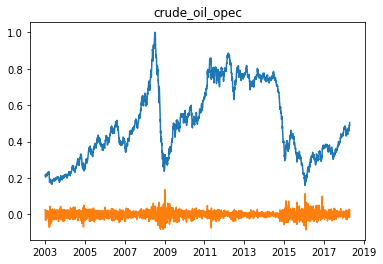

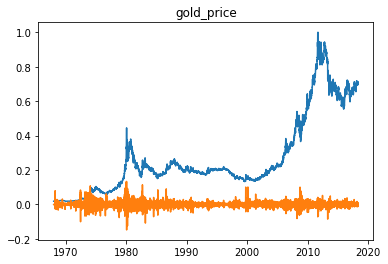

In [11]:
mc_data = get_macro_data()
analyse_macro_data(mc_data,googl_df,True)

In [12]:
def sum_before_index(series,intersect_index):    
    intersect_series = pd.DataFrame(series,index=intersect_index).as_matrix()
    for pos,i in enumerate(intersect_index):
        ## Loops through the allowed indexes, returns a series of values greater than the previous value 
        ## and less than or equal to the current value.
        ##                                  previous value           current index              current value       
        current_sum = series[(pos != 0) & (intersect_index[pos-1] < series.index) & (series.index <= i) | (series.index == i)].sum()
        intersect_series[pos][0] = current_sum
    return pd.DataFrame(intersect_series,index=intersect_index, columns=['Rolling_Sum'])

In [13]:
def compare_pct_change(ms_1, ms_2,display=False):
    start_date = max(ms_1.start_date, ms_2.start_date)
    
    idx1 = ms_1.df.index
    idx2 = ms_2.df.index
    idx_union_merged = idx1.union(idx2)
    idx_intersect_merged = idx1.intersection(idx2) ## Need to convert so that the less frequent date is used as the basis rather than simply when both match
    
    spot_df_1 = pd.DataFrame(ms_1.df.iloc[:,1].rename('ms_1_norm'),index=idx_union_merged)
    spot_df_2 = pd.DataFrame(ms_2.df.iloc[:,1].rename('ms_2_norm'),index=idx_union_merged)
    
    pct_srs_1 = sum_before_index(ms_1.df.iloc[:,2].rename('ms_1_pct_change'),idx_intersect_merged)
    pct_srs_2 = sum_before_index(ms_2.df.iloc[:,2].rename('ms_2_pct_change'),idx_intersect_merged)
    
    pct_df_1 = pd.DataFrame(ms_1.df.iloc[:,2].rename('ms_1_pct_change'),index=idx_intersect_merged)
    pct_df_2 = pd.DataFrame(ms_2.df.iloc[:,2].rename('ms_2_pct_change'),index=idx_intersect_merged)
    
    spot_merged = spot_df_1.join(spot_df_2).fillna(method='ffill')
    pct_merged = pct_df_1.join(pct_df_2)
    
    spot_merged = spot_merged[(spot_merged.index > start_date)]
    pct_merged = pct_merged[(pct_merged.index > start_date)]
    
    if display:
        plt.figure(1)
        plt.plot(spot_merged)
        plt.title("Spot Normalised: " + ms_1.name + " - " + ms_2.name)
        plt.figure(2)
        plt.plot(pct_merged)
        plt.title("Pct Change Normalised: " + ms_1.name + " - " + ms_2.name)
    return spot_merged

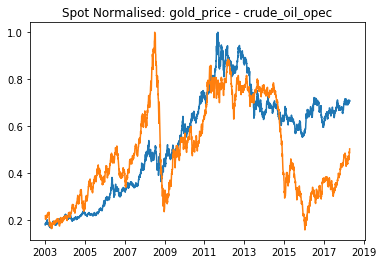

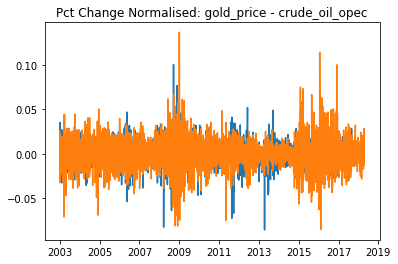

In [14]:
mg = compare_pct_change(mc_data['gold_price'],mc_data['crude_oil_opec'],True)

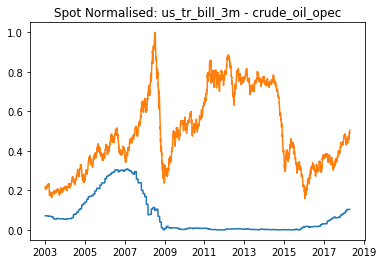

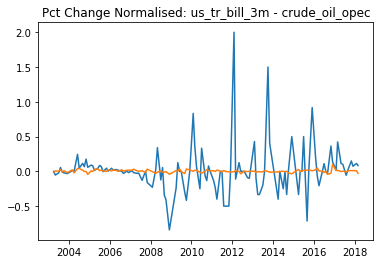

In [15]:
mg = compare_pct_change(mc_data['us_tr_bill_3m'],mc_data['crude_oil_opec'],True)

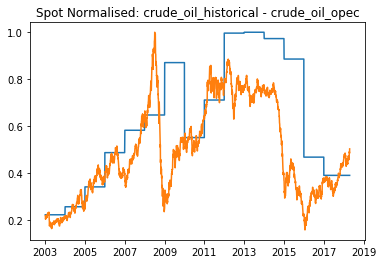

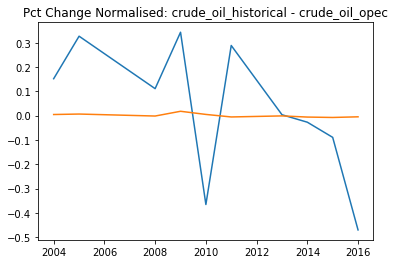

In [16]:
mg = compare_pct_change(mc_data['crude_oil_historical'],mc_data['crude_oil_opec'],True)

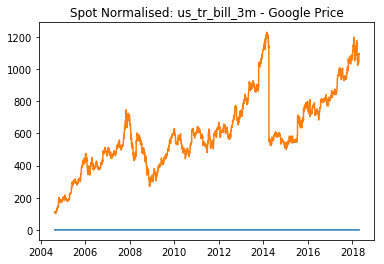

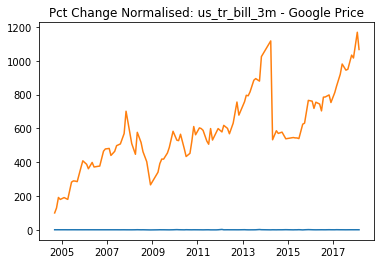

In [17]:
mg = compare_pct_change(mc_data['us_tr_bill_3m'],googl_df,True) ## Bug stocks need to be normalised

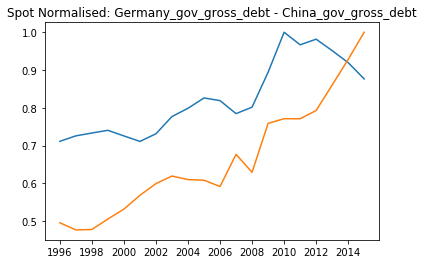

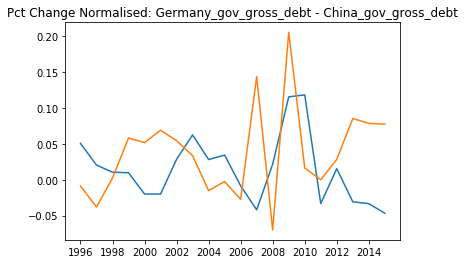

In [18]:
mg = compare_pct_change(mc_data['gov_gross_debt'][0],mc_data['gov_gross_debt'][4],True)

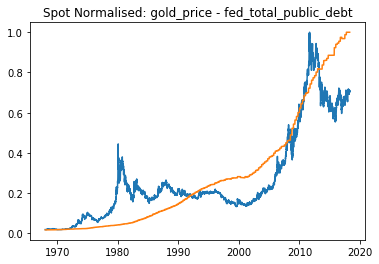

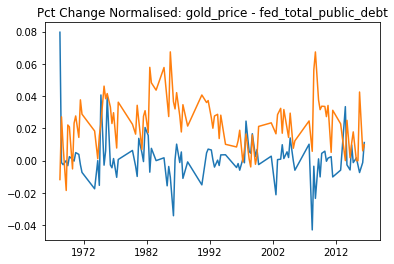

In [19]:
mg = compare_pct_change(mc_data['gold_price'],mc_data['fed_total_public_debt'],True)